# 1. Introduction

The objective of this project is to perform statistical and spectral analysis of wave elevation time-series by analyzing a sample of the heave movements of a buoy deployed along the coast of Rio Grande do Sul, Brazil. This report describes procedures and equations used to arrive at results to the problems set out in the project specifications, always discussing them in the light of applied physical-mathematical modeling discussed in class.

# 2. Dataset

The chosen sample contains data for the 31st of August 2009, measured at latitude -31,56667 and longitude -49.86667, located close to the city of Tavares, as shown in the figure below:

<br />
<img src="images/BuoyLatLong.png" alt="Latitude and Longitude of Buoy" width="600" />
<br />

The sample data is stored in a file with a .tsr extension named "Sample", with each line providing, for an instant in time (first column), corresponding data of "heave", "etaEW" and "etaNS" (second, third and fourth columns, respectively). The figure below contains a screenshot of the initial part of the sample:

<br />
<img src="images/SampleExample.png" alt="Sample Example" width="400" />
<br />

It appears from the data that the sampling interval is of 0.78 seconds, which corresponds to a frequency of 1.28 hertz. To facilitate data manipulation throughout this report, we convert data from the Sample.tsc file to a python array:

In [1]:
SampleFile = open('Sample.tsr','r')

# We get all the lines of the Sample file, except the first three because they contain headers
dataStartIndex = 3
unformattedLines = SampleFile.readlines()[dataStartIndex:]

def formatLine(line):
    '''Lines come as a string with the following format "   0.8\t  0.800\t   0.410000\t   0.470000\n". 
    This function convert this is string into an array like [0.8, 0.8, 0.41, 0.47], where each element
    in the array corresponds to time, heave, etaEW and etaNS, respectively'''
    return list(map(float, line.split()))

pythonSampleArray = list(map(formatLine, unformattedLines))

We then install the following packages: 

1. Numpy, to help us make certain array operations faster and easier;
2. MatPlotLib, to help us plot data; and
3. Scipy, to provide us algorithms for running data analysis.

If any error indicating the need to install these packages occurs when running this notebook, uncomment the cell below and run it to install them.

In [2]:
# ! pip install numpy
# ! pip install matplotlib
# ! pip install scipy

We import the mentioned packages as officially advised and adopted by the community and import other python native packages. All of them are then available for use in the next cells of this report.

In [3]:
# Community packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Native packages
import math

(since all of the interesting functions in Scipy are actually located in submodules, Scipy algotithms are imported as needed) 

Then we stratify the sample data into arrays containing parameter data (heave, etaNS, etaEW) and unify them again into an array (named "parameters") with dictionaries containing information for each parameter - this way, when we iterate over this array, we have all the information we may need for each parameter.

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

times, heaves, etaEWs, etaNSs = [], [], [], []
for time, heave, etaEW, etaNS in pythonSampleArray:
    times.append(time)
    heaves.append(heave)
    etaEWs.append(etaEW)
    etaNSs.append(etaNS)

# We still have each parameter with its relevant information available
time = { "name": "Time", "data": times, "unity": "seconds" }
heave = { "name": "Heave", "data": heaves, "unity": "meters" }
etaEW = { "name": "etaEW", "data": etaEWs, "unity": "meters" }
etaNS = { "name": "etaNS", "data": etaNSs, "unity": "meters" }

# But this way we can easily iterate through the array
parameters = [time, heave, etaEW, etaNS]

To get a visual sense of what's going on, we plot a graph of the heave against time for the entire and a subset of the time interval:

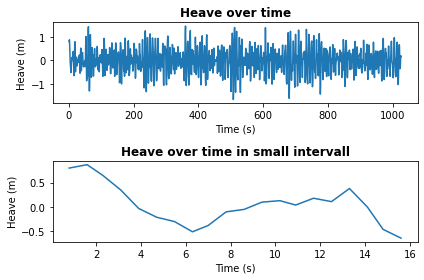

In [5]:
# We create a figure made of 2 different plots
fig, ax = plt.subplots(2)

ax[0].plot(times, heaves) # We put all time values on x axis and heave values on y axis of the first plot
ax[0].set_title("Heave over time", fontweight ="bold")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Heave (m)")

smallTimeInterval, smallHeaveInterval = times[0:20], heaves[0:20] # In the second plot, we analyse a smaller interval
ax[1].plot(smallTimeInterval, smallHeaveInterval)
ax[1].set_title("Heave over time in small intervall", fontweight ="bold")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Heave (m)")

plt.tight_layout() # This ensures that plots do not overlap
plt.show() # Command to effectively show plots

# 3. Part One - Analysis of Individual Waves.

## 3.1 Mean, dispersion (variance), skewness, and kurtosis (first four moments)

"In mathematics, the moments of a function are quantitative measures related to the shape of the function's graph. If the function is a probability distribution, then the first moment is the expected value, the second central moment is the variance, the third standardized moment is the skewness, and the fourth standardized moment is the kurtosis". Calculating these moments, it is possible to gain insights into whether the data obtained is compatible with what is expected. The formulas for each of these moments is presented below:


**Mean**
<br />
$x = \frac{1}{N} \sum_{i=1}^{N} x_i$

**Variance**
<br />
$σ = \frac{1}{N-1} \sum_{i=1}^{N} (x_i - x)^2$

**Skew**
<br />
$S = \frac{1}{N} \sum_{i=1}^{N} \frac {(x_i - x)^3}{σ}$

**Kurtosis**
<br />
$K = \frac{1}{N} \sum_{i=1}^{N} \frac {(x_i - x)^4}{σ}$

Using these definitions, we can calculate the four moments for each parameter (except time, which is not relevant to our analysis):

In [6]:
from scipy.stats import skew, kurtosis

meanList, varianceList, skewnessList, kurtosisList = [], [], [], []
parametersWithoutTime = parameters[1:] 
for parameter in parametersWithoutTime:
    data = parameter["data"] # it can be heave, etaNS, etc...
    # Inserting the moments in its corresponding lists
    meanList.append(np.mean(data))  # Using numpy to calculate mean
    varianceList.append(np.var(data)) # Using numpy to calculate variance
    skewnessList.append(skew(data)) # Using scipy to calculate skewness
    # Using scipy to calculate Kurtosis. fisher=False means it is not the extreme kurtosis
    kurtosisList.append(kurtosis(data, fisher=False)) 

probabilisticMoments = [meanList, varianceList, skewnessList, kurtosisList]

And present them in a table:

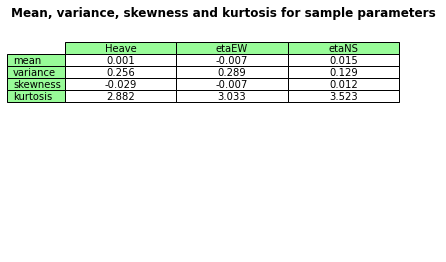

In [7]:
fig, ax = plt.subplots(1)
ax.set_axis_off() # As we don't want to show x and y axis in a table 

rowLabels = ["mean", "variance", "skewness", "kurtosis"] # Labels in row headers
table = ax.table(
    # Data
    colLabels = [parameter["name"] for parameter in parametersWithoutTime], # Labels in column headers: heave, etaEW, etc...
    rowLabels = rowLabels, 
    cellText = [[round(moment, 3) for moment in momentList] for momentList in probabilisticMoments], # We
    # Styles
    rowColours =["palegreen"] * len(rowLabels), # Color of row headers
    colColours =["palegreen"] * len(parametersWithoutTime), # Color of column headers
    cellLoc ='center', # Position of data in table cell
    loc ='upper left') # Position of table in Jupyther cell        

ax.set_title("Mean, variance, skewness and kurtosis for sample parameters \n", fontweight ="bold") # \n means we jump a line
plt.show() 

<h1 style="color:red">TODO:</h1> Analyse results from table. Are the values close to expected? What's the meaning of a kurtosis of 3? And a skewness of -0.029?

## Validation 
To ensure that the results previously obtained with numpy and other libraries are correct, we check if they are consistent with what we expect with the creation of our own functions for probabilistic moments.


<h1 style="color:red">TODO:</h1> Hide validation cells on delivery

In [8]:
# You don't need to read this unless you want to understand how tests were made

def mockMean(arr):
    return sum(arr)/len(arr)

def mockVariance(arr):
    mean_ = mockMean(arr)
    sum_ = 0
    for value in arr:
        sum_ += (value - mean_)**2
    return (sum_ / (len(arr) - 1))

def mockStandardDeviation(arr):
    return math.sqrt(mockVariance(arr))

def mockSkew(arr):
    mean_ = mockMean(arr)
    sum_ = 0
    for value in arr:
        sum_ += (value - mean_)**3
    return (sum_ / (len(arr) * mockStandardDeviation(arr)**3))

def mockKurtosis(arr, fisher=False):
    mean_ = mockMean(arr)
    sum_ = 0
    for value in arr:
        sum_ += (value - mean_)**4
    
    valueToSubtract = 3 if fisher else 0
    return ((sum_ / (len(arr) * mockStandardDeviation(arr)**4)) - valueToSubtract)


def validateMoments(shouldPrint=False, atol=1e-08, rtol=1):
    '''Verify if moments obtained are consisted with expected from 
    our own defined functions'''
    
    def buildAssertionMoments():
        '''For each parameter, calculate its moments with our
        own defined functions and returns them as an array of 
        arrays'''
        
        ms, vs, sks, kurts = [], [], [], []
        for parameter in parametersWithoutTime:
            data = parameter["data"]
            ms.append(mockMean(data))
            vs.append(mockVariance(data))
            sks.append(mockSkew(data))
            kurts.append(mockKurtosis(data))
        return [ms, vs, sks, kurts]
        
    assertionMoments = buildAssertionMoments()
    for i, assertionMoment in enumerate(assertionMoments):
        moment = probabilisticMoments[i]
        foundError = False
        try:
            # We assert the moment is close enough to the moment calculated with our
            # own defined functions
            assert(np.allclose(moment, assertionMoment, atol=atol, rtol=rtol))
        except:
            print(f"Seems like the array corresponding to moment: {moment} is not close enough to {assertionMoment}")
            print("\n")
            foundError = True
            
    if (foundError == False):
        print("All assertions passed 🥳🥳")
    
    if (shouldPrint == True):
        # This can help to debug and compare values
        print("\n -------Printing moments and assertion moments------- \n")
        for i, assertionMoment in enumerate(assertionMoments):
            moment = probabilisicMoments[i]
            print(f"Moment: {moment}.")
            print(f"Assertion Moment: {assertionMoment}")
            print("\n")
        print("\n")
    
    
validateMoments(shouldPrint=False)

All assertions passed 🥳🥳


## 3.2 Distribution of Free Surface Elevation
(in comparison with Gaussian and Longuet-Higgins distributions)


With the mean heave being zero, the Longuet-Higgins distributions gets the follow
equation:

<h1 style="color:red">TODO:</h1> Derive the equations in more detail, write them as markdown and make them more clear: separate x and eta in formulas

<br />
<img src="images/[DELETE_LATER] LHformula.png" alt="Sample Example" width="400" />
<br />

In [9]:
def longuetHigginsDist(etas, mean, standardDeviation, skew, extremeKurtosis):
    '''Receives a list of surface elevations [TODO: Verify if surface elevations or heave] (etas),
    the first four probabilistc moments (with the extreme kurtosis, which is kurtosis - 3) and
    returns a list of densities for the probabilistic distribution'''
    def x(eta): return eta/standardDeviation
    def H3(x): return x**3 - 3*x 
    def H4(x): return x**4 - 6*(x**2) + 3
    def H6(x): return x**6 - 15*(x**4) + 45*(x**2) - 15
    
    def normalDist(eta):
        return norm.pdf(eta, loc=mean, scale=standardDeviation)
    
    def multiplyingFactor(eta):
        lambda3 = skew/6
        lambda4 = extremeKurtosis
        first = (lambda3/math.factorial(3))*H3(x(eta))
        second = (lambda4/math.factorial(4))*H4(x(eta))
        third = ((lambda3**2)/72)*H6(x(eta))
        return 1 + first + second + third
    
    def f(eta):
        return normalDist(eta)*multiplyingFactor(eta)
    
    densities = []
    for eta in etas:
        density = f(eta)
        densities.append(density)
    return densities

We use the data to construct a histogram (that is, a diagram consisting of rectangles whose area is proportional to the frequency of a variable and whose width is equal to the class interval) and compare the results with Gaussian and Longuet-Higgins distributions (with the probabilistic moments of the data as inputs).

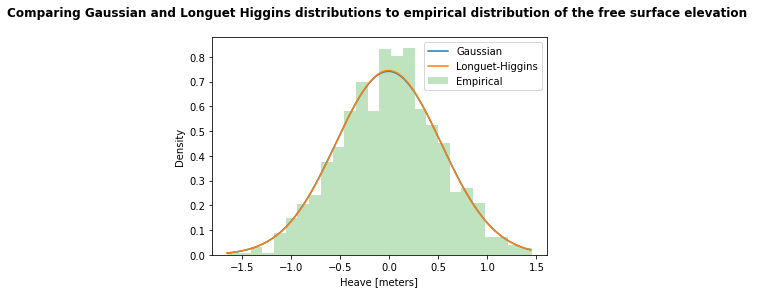

In [10]:
from scipy.stats import norm

# Data relatied to the analyzed parameter (abbreviated as "p") from parameters
# TODO: Change this later if we already know what parameter is going to be analysed
pIndex = 1 # 1=heave, 2=etaEW, etc...
pMean, pVariance, pSkew, pKurtosis = meanList[pIndex], varianceList[pIndex], skewnessList[pIndex], kurtosisList[pIndex]
pStandardDeviation = math.sqrt(pVariance)
data = parameters[pIndex]["data"]

# Determining best bin fit for data and corresponding x interval
# For more details, see:
# https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges
_, bins = np.histogram(data, bins="auto", density=True)
x = np.arange(min(bins), max(bins), 0.01)

# Calculating densities of Gaussian and Longuet-Higgins distributions
gaussian = norm.pdf(x, loc=pMean, scale=pStandardDeviation)
longuetHiggins = longuetHigginsDist(x, 
    mean=pMean,
    standardDeviation=pStandardDeviation, 
    skew=pSkew,
    extremeKurtosis=pKurtosis-3) # Extreme kurtosis is just kurtosis - 3


# Ploting Gaussian, Longuet and empirical data in the same figure
fig, ax = plt.subplots(1)
ax.plot(x, gaussian, label="Gaussian")
ax.plot(x, longuetHiggins, label="Longuet-Higgins")
ax.hist(data, bins=bins, density=True, alpha=0.3, label="Empirical")
ax.legend(loc="best") # Optimal position for labels
ax.set_title("Comparing Gaussian and Longuet Higgins distributions to empirical distribution of the free surface elevation \n", 
             fontweight ="bold") 
name = parameters[pIndex]["name"]
unity = parameters[pIndex]["unity"]
ax.set_xlabel(f"{name} [{unity}]")
ax.set_ylabel("Density")
plt.show()

<h1 style="color:red">TODO:</h1> Write about the result of the graph. As it is, the Gaussian and Longuet-Higgins distribution seem too close - which may be indicating a mistake in calculations or a bad bin distribution

## 3.3 Identify Up-crossing and Down-crossing individual waves and associated periods
Representing wave heights in a histogram and comparing with the Rayleigh distribution.

"The standard method of determining the short-term statistics of a wave record is through the zero-crossing analysis. Either the so-called zero-upcrossing method or the zero-downcrossing method may be used; the obtained statistics should be the same for both methods when using a sufficiently long sample. 

For the zero-upcrossing method, the mean water level is first determined. The wave record is marked each time the water surface crosses the mean level in an upward direction. Individual waves are then identified between the upcrossings and the individual wave height, $H_i$, and wave period, $T_i$, are determined, where i is an index counter to identify each wave. An equivalent procedure is used to determine waves with the zero-downcrossing method, with the waves marked each time the water surface crosses the mean level in a downward direction.

We can mark the waves with the following procedure:
1. Subtract the mean for each ~~water level~~ (CHANGE THIS IF HEAVE/etaNS, ...) value
2. Convert each obtained value to a signal (if the value is positive, it is converted to +1. If is
   negative, -1. And if is 0, it continues to be 0)
3. For each signal, get the difference between the current signal and the last signal.
    3.1. If the difference is 2, it means the last signal (and consequently ~~water level~~) was
    **negative** and the current is **positive** (+1 - (-1) = 2). So it means it is an **up-crossing wave**.
    3.2. If the difference is -2, it means the last signal (and consequently ~~water level~~) was
    **positive** and the current is **negative** (-1 - 1 = -2). So it means it is a **down-crossing wave**.
4. Mark the indexes for each occurence of a zero-crossing in each case (up or down) and then use those 
   indexes to extract wave statistics


<h1 style="color:red">TODO:</h1> Correct ~~water level"~~ names

In [11]:
# We subtract the mean for each heave value
heavesWithMeanSubtracted = np.asarray(heave["data"]) - np.mean(heave["data"])

# We convert those heave with the mean subtracted values to signals
# that is, it returns -1 if heave < 0, 0 if heave==0, 1 if heave > 0 
# https://numpy.org/doc/stable/reference/generated/numpy.sign.html?highlight=sign#numpy.sign
signals = np.sign(heavesWithMeanSubtracted)

# We compute the difference between signals, that is, for i being an
# index, diff[i] = signal[i+1] - signal[i]
# https://numpy.org/doc/stable/reference/generated/numpy.diff.html
diffs = np.diff(signals)

# We then find the indexes (refering to heavesWithMeanSubtracted) 
# of values in diffs. If the difference between two consecutive signals were equal
# to 2, it means it is an up crossing, and if it is equal to - 2, it is a down crossing.
# https://numpy.org/doc/stable/reference/generated/numpy.where.html?highlight=where#numpy.where
upCrossingIndexes = np.where(diffs == 2)[0]
downCrossingIndexes = np.where(diffs == -2)[0]


# IMPORTANT: here we define how an individual wave is modeled, that is, 
# wave = [waveNumber, waveHeight, wavePeriod]
# Data from waves will be referenced through the report
def getWaves(crossingIndexes):
    '''Receives the indexes of a zero-crossing analysis and
    returns a list of waves, each wave containing its number 
    (from the order it appears), height, period and order 
    (rank of height, ie, the biggest wave will be 1, the second
    biggest 2, and so on)'''
    times, heaves = time["data"], heave["data"]
    
    waves = []
    lastIndex = 0
    for i, index in enumerate(crossingIndexes):
        number = i + 1
        height = max(heaves[lastIndex:index])
        period = times[index] - times[lastIndex]
        wave = [number, height, period] # This defines the type of a wave
        waves.append(wave)
        lastIndex = index
    
    def getOrders():
        '''Easyest way to rank an array. See:
        https://codereview.stackexchange.com/questions/65031/creating-a-list-containing-the-rank-of-the-elements-in-the-original-list'''
        heights = [wave[1] for wave in waves]
        orders = [0] * len(heights)    
        for i, x in enumerate(sorted(range(len(heights)), key=lambda y: heights[y], reverse=True)):
            orders[x] = i + 1
        return orders
    
    # Appending orders in each wave
    orders = getOrders()
    for i, wave in enumerate(waves):
        wave.append(orders[i])
    return waves

upCrossingWaves = getWaves(upCrossingIndexes)
downCrossingWaves = getWaves(downCrossingIndexes)

In [12]:
def plotWavesTable(waves, direction):
    '''Receives a list of waves and the corresponding crossing analysis direction
    and plots a table with its number, height, period and order'''
    fig, ax = plt.subplots(1)
    ax.set_axis_off()

    colLabels = ["Wave Number", "Wave Height H(m)", "Wave Period T(s)", "Order Number"]
    table = ax.table(
        colLabels = colLabels,
        cellText = [[round(val, 3) for val in wave]for wave in waves],
        colColours =["palegreen"] * len(colLabels), 
        cellLoc ='center',  
        loc ='upper left')         
    
    ax.set_title(f"Wave Numbers, Heights, Periods and Orders from a zero-{direction}crossing analysis \n", fontweight ="bold") 
    plt.show()

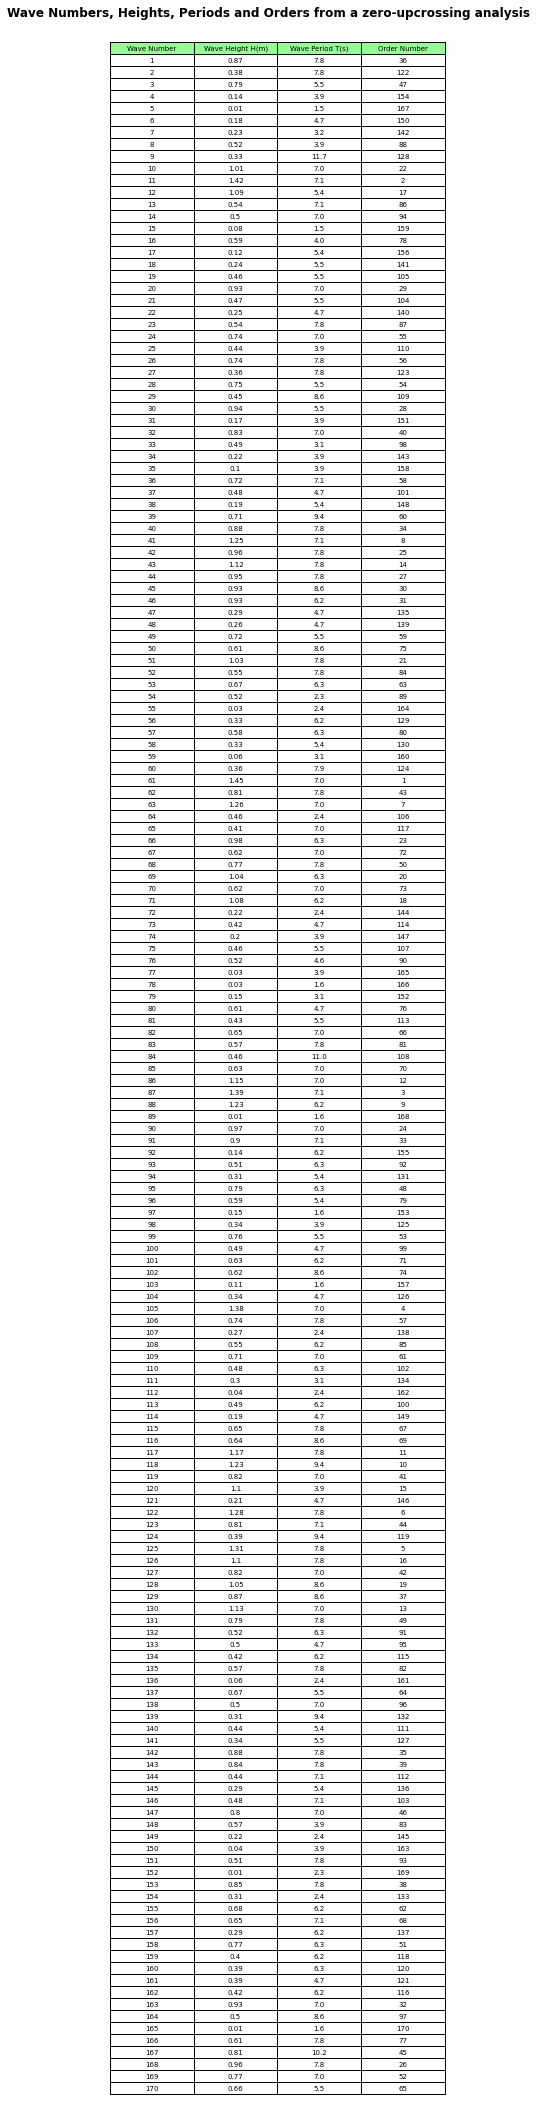

In [13]:
plotWavesTable(upCrossingWaves, direction="up")

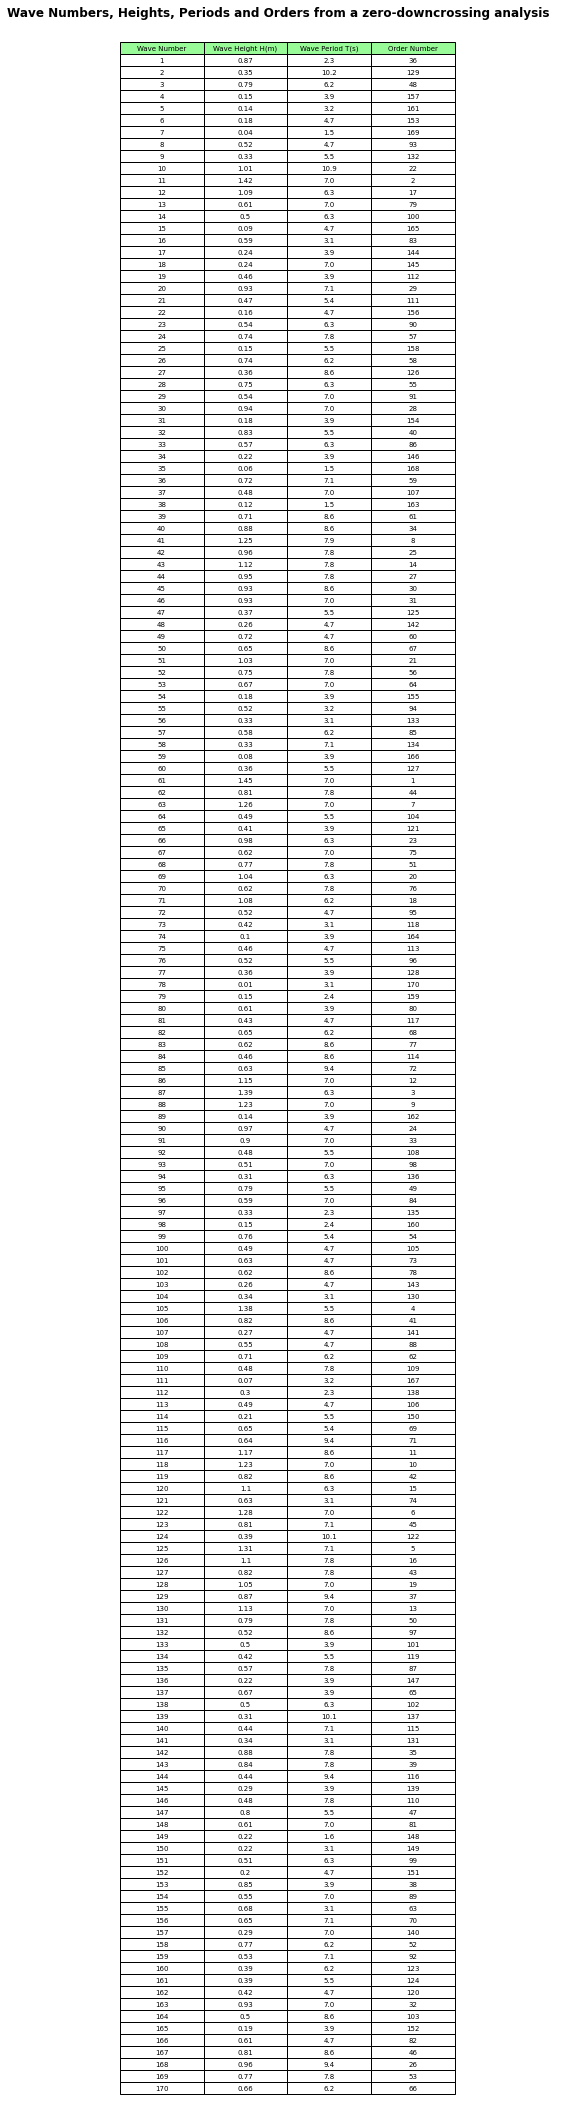

In [14]:
plotWavesTable(downCrossingWaves, direction="down")

In [27]:
def getWavesStatistics(waves):
    '''Receives a list of waves and returns its mean height, maximum height,
    the period corresponding to the maximum height wave and the number of waves'''
    heights, periods = [], []
    for wave in waves:
        heights.append(wave[1])
        periods.append(wave[2])
    
    meanHeight = np.mean(heights)
    maxHeight = np.amax(heights)
    maxHeightIndex = np.where(heights == maxHeight)[0][0]
    maxHeightPeriod = periods[maxHeightIndex]
    numberOfWaves = len(waves)
        
    return [round(meanHeight, 6), round(maxHeight, 6), round(maxHeightPeriod, 6), numberOfWaves]

# We get the statistics for both up and down-crossing waves
upCrossingStats = getWavesStatistics(upCrossingWaves)
downCrossingStats = getWavesStatistics(downCrossingWaves)

6.016470588235294
6.002352941176471


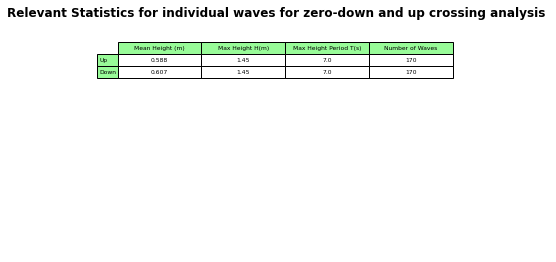

In [16]:
def plotWavesStatsTable(upCrossingStats, downCrossingStats):
    '''Receives statistics from up and downcrossing waves and
    plots a table showing these statistics'''
    fig, ax = plt.subplots(1)
    ax.set_axis_off()

    colLabels = ["Mean Height (m)", "Max Height H(m)", "Max Height Period T(s)", "Number of Waves"]
    rowLabels = ["Up", "Down"]
    stats = [upCrossingStats, downCrossingStats]
    table = ax.table(
        colLabels = colLabels,
        rowLabels = rowLabels,
        cellText = [[round(val, 3) for val in stat] for stat in stats],
        colColours =["palegreen"] * len(colLabels),
        rowColours =["palegreen"] * len(rowLabels), 
        cellLoc ='center',  
        loc ='upper left')         
    
    ax.set_title(f"Relevant Statistics for individual waves for zero-down and up crossing analysis \n", fontweight ="bold") 
    plt.show()
    
plotWavesStatsTable(upCrossingStats, downCrossingStats)

<h1 style="color:red">TODO:</h1> Write about obtained results in table
We got the same height and max period, same number of waves, but different mean height: why?

In [17]:
from scipy.stats import rayleigh

def plotRayleighComparison(waveHeights, direction):
    '''Receives a list of wave heights and a direction (up or down)
    and plots an histogram those wave heights with a corresponding
    Rayleigh distribution fitted to these wave heights'''
    # Determining best bin fit for wave heights and corresponding x interval
    _, bins = np.histogram(waveHeights, bins="auto", density=True)
    x = np.arange(min(bins), max(bins), 0.01)
    
    # Calculating densities of Rayleigh distribution
    loc, scale = rayleigh.fit(upCrossingWaveHeights)
    rayleighDensities = rayleigh.pdf(x, scale=scale, loc=loc)
    
    
    # Ploting Rayleigh distribution and empirical data in the same figure
    fig, ax = plt.subplots(1)
    ax.plot(x, rayleighDensities, label="Rayleigh")
    ax.hist(waveHeights, bins=bins, density=True, alpha=0.3, label="Empirical")
    ax.legend(loc="best")
    ax.set_title(f'''Comparing Rayleigh distribution to empirical distribution of Wave Heights
        for zero-{direction} crossing analysis \n''', fontweight ="bold")
    ax.set_xlabel("Individual Wave Height (m)")
    ax.set_ylabel("Density")
    plt.show()

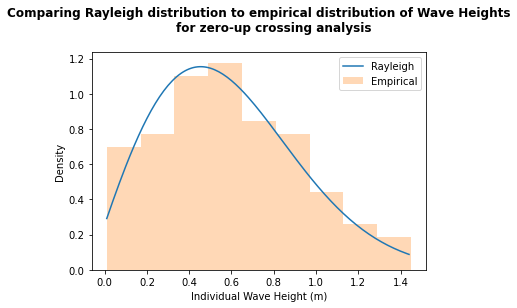

In [18]:
upCrossingWaveHeights = [wave[1] for wave in upCrossingWaves]
plotRayleighComparison(upCrossingWaveHeights, direction="up")

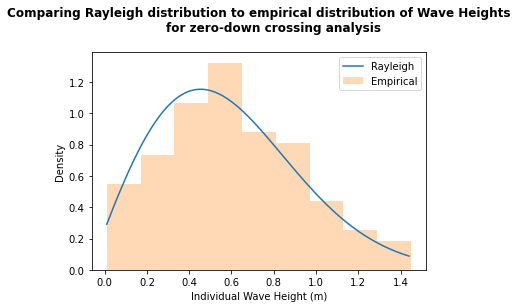

In [19]:
downCrossingWaveHeights = [wave[1] for wave in downCrossingWaves]
plotRayleighComparison(downCrossingWaveHeights, direction="down")

<h1 style="color:red">TODO:</h1> Write about obtained results. Does the Rayleigh distribution fits? Is it suppose to?

## 3.4 Significant wave height and significant wave period.
(and comparison of significant wave height to mean wave height and maximum wave height)

<h1 style="color:red">TODO:</h1> Rewrite this introduction with my own words and correct markdown

"The most widely used statistical wave height for a short term wave record is the so-called significant height, denoted as either Hs or as H113 or as HJJ, The significant wave height is defined as the mean or average of the largest one-third of the waves in the wave record, hence the notation H113 or H33 symbolizing the average of the largest 33% of the waves in the record."

With the rank ordered wave heights, we can calculate the significant wave height by considering the average of the top
one-third (N/3) of the rank-ordered waves as: 

**Significant Wave Height**
<br />
$H_s = \frac{1}{N/3} \sum_{i=1}^{N/3} H_i$

Similarly, for the significant period we have:


**Significant Period**
<br />
$T_s = \frac{1}{N/3} \sum_{i=1}^{N/3} T_i$

By calculating those values, we get:

In [20]:
def getWavesSignificantStatistics(waves, direction):
    '''Receives a list of waves and a direction (up or down) and
    returns an array containing the significant height and significant
    period, respectively'''
    
    # TODO: how should we approximate this limit if is a decimal number?
    # For instance, if len(waves) is 170, 170 divided by 3 is approximately
    # 56,7. Should we use the top third as 56 or 57?
    topThird =int(round(len(waves)/3))
    sHeightSum, sPeriodSum = 0, 0
    for wave in waves:
        order = wave[3]
        if order <= topThird:
            height = wave[1]
            period = wave[2]
            sHeightSum += height
            sPeriodSum += period
    
    significantHeight = sHeightSum / topThird
    significantPeriod = sPeriodSum / topThird
    
    def printStats():
        print(f"Significant Height for zero-{direction} crossing method: {significantHeight}")
        print(f"Significant Period for zero-{direction} crossing method: {significantPeriod} \n")
        
    printStats()
    return [significantHeight, significantPeriod]

upCrossingSignificantStats = getWavesSignificantStatistics(upCrossingWaves, direction="up")
downCrossingSignificantStats = getWavesSignificantStatistics(downCrossingWaves, direction="down")

Significant Height for zero-up crossing method: 0.9815789473684213
Significant Period for zero-up crossing method: 7.178947368421055 

Significant Height for zero-down crossing method: 0.9831578947368425
Significant Period for zero-down crossing method: 7.098245614035091 



Then we can compare significant height with average and maximum heights:

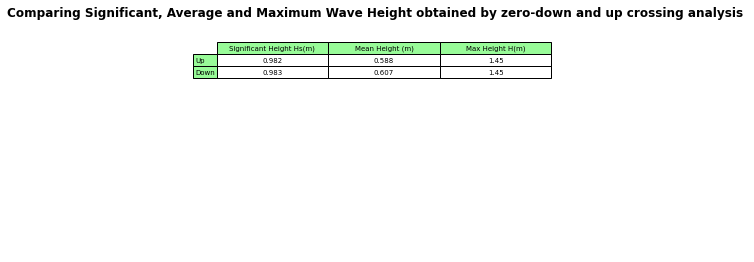

In [21]:
# Unifing up-crossing heights
upCrossingSignificantHeight = upCrossingSignificantStats[0]
upCrossingAverageHeight, upCrossingMaximumHeight = upCrossingStats[0], upCrossingStats[1]
allUpCrossingHeights = [upCrossingSignificantHeight, upCrossingAverageHeight, upCrossingMaximumHeight]

# Unifing down-crossing heights
downCrossingSignificantHeight = downCrossingSignificantStats[0]
downCrossingAverageHeight, downCrossingMaximumHeight = downCrossingStats[0], downCrossingStats[1]
allDownCrossingHeights = [downCrossingSignificantHeight, downCrossingAverageHeight, downCrossingMaximumHeight]


def plotHeightsComparison(upHeights, downHeights):
    '''Receives up and downcrossing heights and plots
    a table comparing them'''
    fig, ax = plt.subplots(1)
    ax.set_axis_off()

    colLabels = ["Significant Height Hs(m)", "Mean Height (m)", "Max Height H(m)"]
    rowLabels = ["Up", "Down"]
    heights = [upHeights, downHeights]
    table = ax.table(
        colLabels = colLabels,
        rowLabels = rowLabels,
        cellText = [[round(val, 3) for val in height] for height in heights],
        colColours =["palegreen"] * len(colLabels), 
        rowColours =["palegreen"] * len(rowLabels), 
        cellLoc ='center',  
        loc ='upper left')         
    
    ax.set_title(f"Comparing Significant, Average and Maximum Wave Height obtained by zero-down and up crossing analysis \n",
                 fontweight ="bold") 
    plt.show()


plotHeightsComparison(allUpCrossingHeights, allDownCrossingHeights)

<h1 style="color:red">TODO:</h1> Rewrite this final part and analyse table results: are they compatible? What's their discrepancy? Is that expected?

"One interesting feature of the significant wave is that it is thought to correspond to the wave conditions that would be estimated visually by an observer looking at a random sea. In other words, the human eye has a natural filtering that tends to exclude the smallest waves and focus instead on the larger waves in the sea state"